# Imports

https://medium.com/@pyashpq56/sentiment-analysis-on-imdb-movie-review-d004f3e470bd

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer, LancasterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

from bs4 import BeautifulSoup
import spacy
import re, string, unicodedata
from nltk.tokenize.toktok import ToktokTokenizer

from textblob import TextBlob, Word

import os
import warnings


In [31]:
imdb_data = pd.read_csv('/content/drive/MyDrive/0datasets/IMdb movie review/IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.tail(10)

(50000, 2)


,review,sentiment
49990,"Lame, lame, lame!!! A 90-minute cringe-fest th...",negative
49991,"Les Visiteurs, the first movie about the medie...",negative
49992,John Garfield plays a Marine who is blinded by...,positive
49993,Robert Colomb has two full-time jobs. He's kno...,negative
49994,This is your typical junk comedy.<br /><br />T...,negative
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [32]:
# summary
imdb_data.describe()


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [33]:
# sentiment_count
imdb_data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

# Text Preprocessing

## text_normalization

In [34]:
# Tokenization
tokenizer = ToktokTokenizer()

# setting eng stopwords
nltk.download('stopwords')
stopword_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# removing html and noise
#removing the html strips
def stirp_html(text):
  soup = BeautifulSoup(text, 'html.parser')
  return soup.get_text()

#removing sq brackets
def remove_sq(text):
  return re.sub('\[[^]]*\]', '', text)

#remove noisy text
def denoise_text(text):
  text = stirp_html(text)
  text = remove_sq(text)
  return text

imdb_data['review'] = imdb_data['review'].apply(denoise_text)

In [36]:
# remove spacial char
def rm_sc(text, remove_digits = True):
  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', text)
  return text

imdb_data['review'] = imdb_data['review'].apply(rm_sc)

In [37]:
#stemming
def simple_stemmer(text):
  ps = PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])
  return text

imdb_data['review'] = imdb_data['review'].apply(simple_stemmer)

>Text normalisation is the process of converting previously uncanonical text into a single canonical form. Because input is guaranteed to be consistent before operations are done on it, normalising text before storing or processing it allows for separation of concerns.

In [38]:
#removing stop words and Normalization
stop = set(stopwords.words('english'))
print(stop)

{'until', 'on', 'is', "wouldn't", 'didn', 'will', 't', "needn't", "you've", 'i', 'that', "doesn't", 'as', 'or', 'all', "hasn't", 'had', 'such', 'are', "she's", 'above', 'once', 'her', 'o', 'into', 'those', 'here', 'a', 'he', 'by', 'from', 'ours', 'its', 'wouldn', 'some', 'be', 'these', 'both', 'during', 'hers', 'weren', 'shan', 'it', 'm', 'shouldn', 'before', 'did', 'how', 'hasn', 'again', 'll', 'theirs', 'only', 'ma', 'mustn', 'she', 'any', "wasn't", 'should', 'won', 'have', 'about', 'just', 'doing', 'up', "won't", 'below', 'whom', 'down', 'who', 'why', "couldn't", 'when', 'they', 'your', 'our', 'most', 'aren', 'y', 'same', 'ain', "you'd", 're', "aren't", 'am', 's', 'which', 'while', 'where', 'been', 'out', 'having', 'over', 'yourself', 'own', 'itself', 'me', 'his', 'after', 'the', "you'll", "shan't", 'herself', 'because', 'and', 'off', "should've", 'through', "that'll", 'between', 'you', 'my', 'mightn', 'then', 'hadn', "don't", 'themselves', "haven't", 'yours', 'an', 'him', 'of', 'ha

In [39]:
#remove stop word
def rm_sw(text, is_lower_case = False):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  if is_lower_case:
    filtered_tokens = [token for token in tokens if token not in stopword_list]
  else:
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

imdb_data['review'] = imdb_data['review'].apply(rm_sw)


In [41]:
#normalize train
norm_train_reviews = imdb_data.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 Oz episod youll hook right thi exactli happen meth first thing struck Oz wa brutal unflinch scene violenc set right word GO trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call OZ nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda Em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast Oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [42]:
# normalize test
norm_test_reviews = imdb_data.review[40000:]
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

## bag of words model

In [43]:
# count vectorizer for bag of words
cv = CountVectorizer(min_df=0,
                     max_df=1,
                     binary=False,
                     ngram_range=(1,3))

# transformed train reviews
cv_train_reviews = cv.fit_transform(norm_train_reviews)

# transformed test reviews
cv_test_reviews = cv.transform(norm_test_reviews)

print(f'BOW_cv_train: {cv_train_reviews.shape}')
print(f'BOW_cv_test: {cv_test_reviews.shape}')
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


## Term Frequency-Inverse Document Frequency model (TFIDF)
>It is used to convert text documents to matrix of tfidf features.
>>The term frequency-inverse document frequency statistic is a numerical measure of how essential a word is to a document in a collection.

In [44]:
tv = TfidfVectorizer(min_df=0,
                     max_df=1,
                     use_idf=True,
                     ngram_range=(1,3))
# transformed train reviews
tv_train_reviews = tv.fit_transform(norm_train_reviews)

# transformed test reviews
tv_test_reviews = tv.transform(norm_test_reviews)

print(f'BOW_tv_train: {tv_train_reviews.shape}')
print(f'BOW_tv_test: {tv_test_reviews.shape}')
#vocab=cv.get_feature_names()-toget feature names

BOW_tv_train: (40000, 6209089)
BOW_tv_test: (10000, 6209089)


Vectorizer used Above: Word Embeddings, also known as Word Vectorization, is an NLP technique for mapping words or phrases from a lexicon to a corresponding vector of real numbers, which can then be used to derive word predictions and semantics. Vectorization is the process of translating words into numbers.

# Labeling the sentiment text and splitting sentiment data
Label Binarizer is a SciKit Learn class that takes Categorical data and outputs a Numpy array. Unlike Label Encoder, it encodes data into dummy variables that indicate whether a specific label is present or not. Label Binarizer is used to encode column data.

In [45]:
#labeling the sentiment data
lb = LabelBinarizer()

sentiment_data = lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

#split data
train_sentiments = sentiment_data[:40000]
test_sentiments = sentiment_data[40000:]

print(train_sentiments)
print(test_sentiments)

(50000, 1)
[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


# Model

In [46]:
mnb = MultinomialNB()

mnb_bog = mnb.fit(cv_train_reviews, train_sentiments)
mnb_tfidf = mnb.fit(tv_train_reviews, train_sentiments)
print(mnb_bog)
print(mnb_tfidf)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()
MultinomialNB()


In [48]:
#predict_bog
mnb_bog_predict= mnb.predict(cv_test_reviews)
print(mnb_bog_predict)
#predict_tfidf
mnb_tfidf_predict= mnb.predict(tv_test_reviews)
print(mnb_bog_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


In [50]:
# Accuracy_bog
mnb_bog_score = accuracy_score(test_sentiments, mnb_bog_predict)
print(f'accuracy_bog:{mnb_bog_score}')
# Accuracy_tfidf
mnb_tfidf_score = accuracy_score(test_sentiments, mnb_tfidf_predict)
print(f'accuracy_tfidf:{mnb_tfidf_score}')

accuracy_bog:0.751
accuracy_tfidf:0.7509


In [51]:
#classification_report_bog
mnb_bog_report = classification_report(test_sentiments, 
                                       mnb_bog_predict,
                                       target_names=['Positive','Negative'])
print(mnb_bog_report)

#classification_report_tfidf
mnb_tfidf_report = classification_report(test_sentiments, 
                                        mnb_tfidf_predict,
                                       target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [53]:
#confusion_matrix_bog
cm_bog = confusion_matrix(test_sentiments, 
                          mnb_bog_predict,
                          labels= [1, 0])
print(cm_bog)
#confusion_matrix_tfidf
cm_tfidf = confusion_matrix(test_sentiments, 
                          mnb_tfidf_predict,
                          labels= [1, 0])
print(cm_tfidf)


[[3736 1271]
 [1219 3774]]
[[3729 1278]
 [1213 3780]]


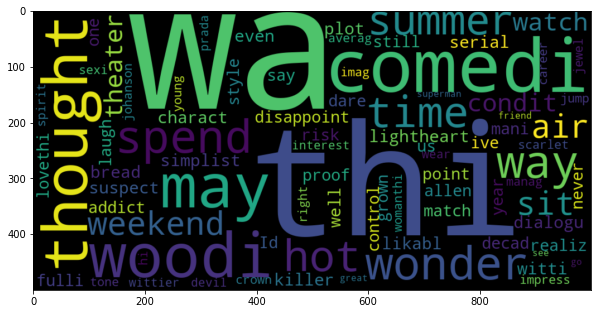

In [56]:
# word cloud for +ve reviews
plt.figure(figsize=(10,10))
positive_text = norm_train_reviews[2]
WC = WordCloud(width=1000,
               height=500,
               max_words=500,
               min_font_size=5)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show()
